
# Speech Enhancement with MVDR Beamforming

**Author**: [Zhaoheng Ni](zni@meta.com)_


## 1. Overview

This is a tutorial on applying Minimum Variance Distortionless
Response (MVDR) beamforming to estimate enhanced speech with
TorchAudio.

Steps:

-  Generate an ideal ratio mask (IRM) by dividing the clean/noise
   magnitude by the mixture magnitude.
-  Estimate power spectral density (PSD) matrices using :py:func:`torchaudio.transforms.PSD`.
-  Estimate enhanced speech using MVDR modules
   (:py:func:`torchaudio.transforms.SoudenMVDR` and
   :py:func:`torchaudio.transforms.RTFMVDR`).
-  Benchmark the two methods
   (:py:func:`torchaudio.functional.rtf_evd` and
   :py:func:`torchaudio.functional.rtf_power`) for computing the
   relative transfer function (RTF) matrix of the reference microphone.




In [1]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)


import matplotlib.pyplot as plt
import mir_eval
from IPython.display import Audio

2.5.1+cu124
2.5.1+cu124


/home/dhruv/Programming/CollegeProjects/Sem5/DAA/Audio-background-noise-cancellation/.venv/lib/python3.12/site-packages/mir_eval/util.py:877: SyntaxWarning: invalid escape sequence '\*'
  """Given a function and args and keyword args to pass to it, call the function
/home/dhruv/Programming/CollegeProjects/Sem5/DAA/Audio-background-noise-cancellation/.venv/lib/python3.12/site-packages/mir_eval/beat.py:1: SyntaxWarning: invalid escape sequence '\%'
  '''
/home/dhruv/Programming/CollegeProjects/Sem5/DAA/Audio-background-noise-cancellation/.venv/lib/python3.12/site-packages/mir_eval/sonify.py:65: SyntaxWarning: invalid escape sequence '\p'
  """Reverse synthesis of a time-frequency representation of a signal
/home/dhruv/Programming/CollegeProjects/Sem5/DAA/Audio-background-noise-cancellation/.venv/lib/python3.12/site-packages/mir_eval/sonify.py:189: SyntaxWarning: invalid escape sequence '\p'
  '''Sonify a pitch contour.
/home/dhruv/Programming/CollegeProjects/Sem5/DAA/Audio-background-noi

## 2. Preparation




### 2.1. Import the packages

First, we install and import the necessary packages.

``mir_eval``, ``pesq``, and ``pystoi`` packages are required for
evaluating the speech enhancement performance.




In [2]:
# When running this example in notebook, install the following packages.
# !pip3 install mir_eval
# !pip3 install pesq
# !pip3 install pystoi

from pesq import pesq
from pystoi import stoi
from torchaudio.utils import download_asset

### 2.2. Download audio data

The multi-channel audio example is selected from
[ConferencingSpeech](https://github.com/ConferencingSpeech/ConferencingSpeech2021)_
dataset.

The original filename is

   ``SSB07200001\#noise-sound-bible-0038\#7.86_6.16_3.00_3.14_4.84_134.5285_191.7899_0.4735\#15217\#25.16333303751458\#0.2101221178590021.wav``

which was generated with:

-  ``SSB07200001.wav`` from
   [AISHELL-3](https://www.openslr.org/93/)_ (Apache License
   v.2.0)
-  ``noise-sound-bible-0038.wav`` from
   [MUSAN](http://www.openslr.org/17/)_ (Attribution 4.0
   International — CC BY 4.0)




In [3]:
SAMPLE_RATE = 16000
SAMPLE_CLEAN = download_asset("tutorial-assets/mvdr/clean_speech.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/mvdr/noise.wav")

100%|██████████| 0.98M/0.98M [00:00<00:00, 1.75MB/s]
100%|██████████| 1.95M/1.95M [00:00<00:00, 2.94MB/s]


### 2.3. Helper functions




In [4]:
def plot_spectrogram(stft, title="Spectrogram"):
    magnitude = stft.abs()
    spectrogram = 20 * torch.log10(magnitude + 1e-8).numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(spectrogram, cmap="viridis", vmin=-100, vmax=0, origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)


def plot_mask(mask, title="Mask"):
    mask = mask.numpy()
    figure, axis = plt.subplots(1, 1)
    img = axis.imshow(mask, cmap="viridis", origin="lower", aspect="auto")
    axis.set_title(title)
    plt.colorbar(img, ax=axis)


def si_snr(estimate, reference, epsilon=1e-8):
    estimate = estimate - estimate.mean()
    reference = reference - reference.mean()
    reference_pow = reference.pow(2).mean(axis=1, keepdim=True)
    mix_pow = (estimate * reference).mean(axis=1, keepdim=True)
    scale = mix_pow / (reference_pow + epsilon)

    reference = scale * reference
    error = estimate - reference

    reference_pow = reference.pow(2)
    error_pow = error.pow(2)

    reference_pow = reference_pow.mean(axis=1)
    error_pow = error_pow.mean(axis=1)

    si_snr = 10 * torch.log10(reference_pow) - 10 * torch.log10(error_pow)
    return si_snr.item()


def generate_mixture(waveform_clean, waveform_noise, target_snr):
    power_clean_signal = waveform_clean.pow(2).mean()
    power_noise_signal = waveform_noise.pow(2).mean()
    current_snr = 10 * torch.log10(power_clean_signal / power_noise_signal)
    waveform_noise *= 10 ** (-(target_snr - current_snr) / 20)
    return waveform_clean + waveform_noise


def evaluate(estimate, reference):
    si_snr_score = si_snr(estimate, reference)
    (
        sdr,
        _,
        _,
        _,
    ) = mir_eval.separation.bss_eval_sources(reference.numpy(), estimate.numpy(), False)
    pesq_mix = pesq(SAMPLE_RATE, estimate[0].numpy(), reference[0].numpy(), "wb")
    stoi_mix = stoi(reference[0].numpy(), estimate[0].numpy(), SAMPLE_RATE, extended=False)
    print(f"SDR score: {sdr[0]}")
    print(f"Si-SNR score: {si_snr_score}")
    print(f"PESQ score: {pesq_mix}")
    print(f"STOI score: {stoi_mix}")

## 3. Generate Ideal Ratio Masks (IRMs)




### 3.1. Load audio data




In [5]:
waveform_clean, sr = torchaudio.load(SAMPLE_CLEAN)
waveform_noise, sr2 = torchaudio.load(SAMPLE_NOISE)
assert sr == sr2 == SAMPLE_RATE
# The mixture waveform is a combination of clean and noise waveforms with a desired SNR.
target_snr = 3
waveform_mix = generate_mixture(waveform_clean, waveform_noise, target_snr)

Note: To improve computational robustness, it is recommended to represent
the waveforms as double-precision floating point (``torch.float64`` or ``torch.double``) values.




In [6]:
waveform_mix = waveform_mix.to(torch.double)
waveform_clean = waveform_clean.to(torch.double)
waveform_noise = waveform_noise.to(torch.double)

### 3.2. Compute STFT coefficients




In [7]:
N_FFT = 1024
N_HOP = 256
stft = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    hop_length=N_HOP,
    power=None,
)
istft = torchaudio.transforms.InverseSpectrogram(n_fft=N_FFT, hop_length=N_HOP)

stft_mix = stft(waveform_mix)
stft_clean = stft(waveform_clean)
stft_noise = stft(waveform_noise)

#### 3.2.1. Visualize mixture speech

We evaluate the quality of the mixture speech or the enhanced speech
using the following three metrics:

-  signal-to-distortion ratio (SDR)
-  scale-invariant signal-to-noise ratio (Si-SNR, or Si-SDR in some papers)
-  Perceptual Evaluation of Speech Quality (PESQ)

We also evaluate the intelligibility of the speech with the Short-Time Objective Intelligibility
(STOI) metric.



AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.

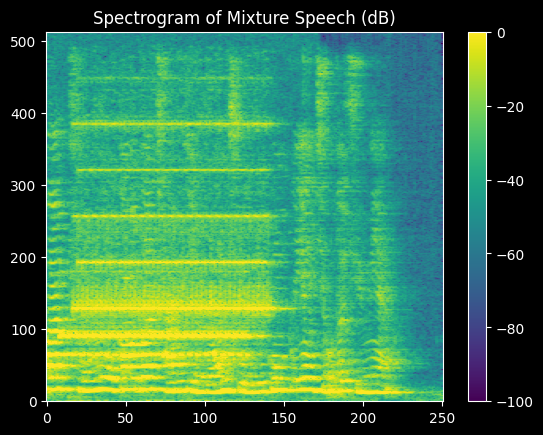

In [8]:
plot_spectrogram(stft_mix[0], "Spectrogram of Mixture Speech (dB)")
evaluate(waveform_mix[0:1], waveform_clean[0:1])
Audio(waveform_mix[0], rate=SAMPLE_RATE)

#### 3.2.2. Visualize clean speech




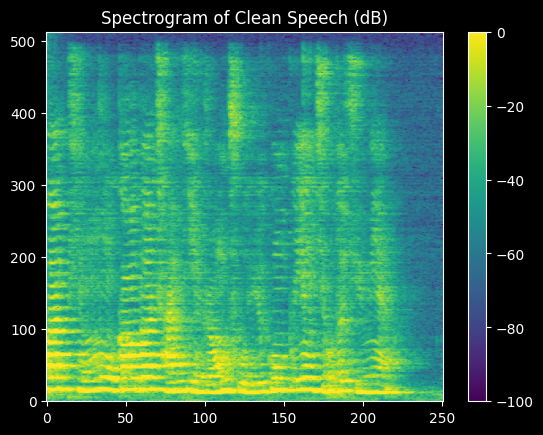

In [9]:
plot_spectrogram(stft_clean[0], "Spectrogram of Clean Speech (dB)")
Audio(waveform_clean[0], rate=SAMPLE_RATE)

#### 3.2.3. Visualize noise




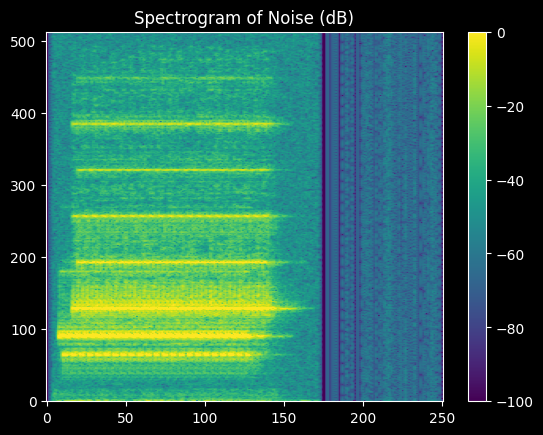

In [10]:
plot_spectrogram(stft_noise[0], "Spectrogram of Noise (dB)")
Audio(waveform_noise[0], rate=SAMPLE_RATE)

### 3.3. Define the reference microphone

We choose the first microphone in the array as the reference channel for demonstration.
The selection of the reference channel may depend on the design of the microphone array.

You can also apply an end-to-end neural network which estimates both the reference channel and
the PSD matrices, then obtains the enhanced STFT coefficients by the MVDR module.



In [11]:
REFERENCE_CHANNEL = 0

### 3.4. Compute IRMs




In [12]:
def get_irms(stft_clean, stft_noise):
    mag_clean = stft_clean.abs() ** 2
    mag_noise = stft_noise.abs() ** 2
    irm_speech = mag_clean / (mag_clean + mag_noise)
    irm_noise = mag_noise / (mag_clean + mag_noise)
    return irm_speech[REFERENCE_CHANNEL], irm_noise[REFERENCE_CHANNEL]


irm_speech, irm_noise = get_irms(stft_clean, stft_noise)

#### 3.4.1. Visualize IRM of target speech




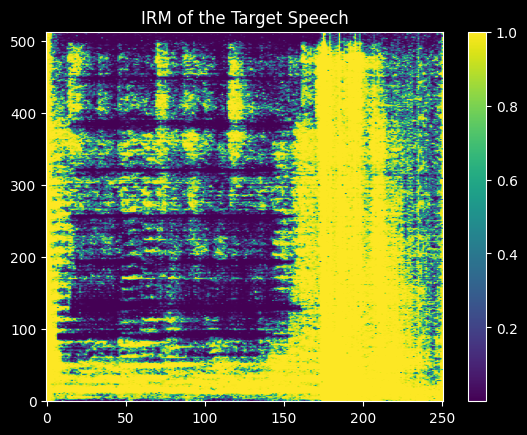

In [13]:
plot_mask(irm_speech, "IRM of the Target Speech")

#### 3.4.2. Visualize IRM of noise




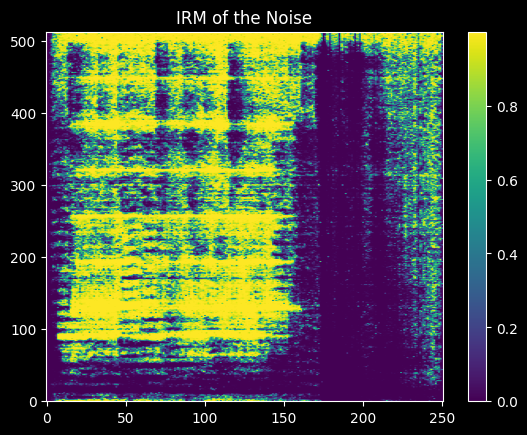

In [14]:
plot_mask(irm_noise, "IRM of the Noise")

## 4. Compute PSD matrices

:py:func:`torchaudio.transforms.PSD` computes the time-invariant PSD matrix given
the multi-channel complex-valued STFT coefficients  of the mixture speech
and the time-frequency mask.

The shape of the PSD matrix is `(..., freq, channel, channel)`.



In [15]:
psd_transform = torchaudio.transforms.PSD()

psd_speech = psd_transform(stft_mix, irm_speech)
psd_noise = psd_transform(stft_mix, irm_noise)

## 5. Beamforming using SoudenMVDR




### 5.1. Apply beamforming

:py:func:`torchaudio.transforms.SoudenMVDR` takes the multi-channel
complexed-valued STFT coefficients of the mixture speech, PSD matrices of
target speech and noise, and the reference channel inputs.

The output is a single-channel complex-valued STFT coefficients of the enhanced speech.
We can then obtain the enhanced waveform by passing this output to the
:py:func:`torchaudio.transforms.InverseSpectrogram` module.



In [16]:
mvdr_transform = torchaudio.transforms.SoudenMVDR()
stft_souden = mvdr_transform(stft_mix, psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)
waveform_souden = istft(stft_souden, length=waveform_mix.shape[-1])

### 5.2. Result for SoudenMVDR




AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.

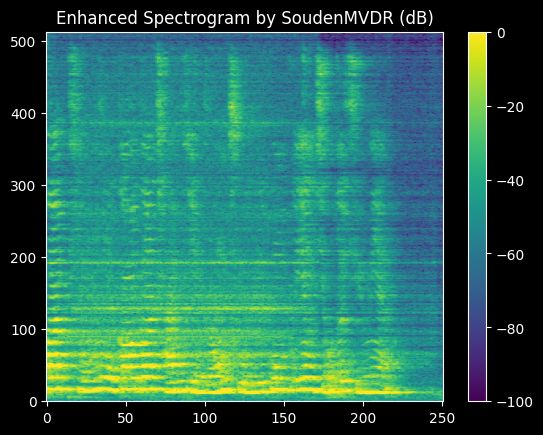

In [17]:
plot_spectrogram(stft_souden, "Enhanced Spectrogram by SoudenMVDR (dB)")
waveform_souden = waveform_souden.reshape(1, -1)
evaluate(waveform_souden, waveform_clean[0:1])
Audio(waveform_souden, rate=SAMPLE_RATE)

## 6. Beamforming using RTFMVDR




### 6.1. Compute RTF

TorchAudio offers two methods for computing the RTF matrix of a
target speech:

-  :py:func:`torchaudio.functional.rtf_evd`, which applies eigenvalue
   decomposition to the PSD matrix of target speech to get the RTF matrix.

-  :py:func:`torchaudio.functional.rtf_power`, which applies the power iteration
   method. You can specify the number of iterations with argument ``n_iter``.




In [18]:
rtf_evd = F.rtf_evd(psd_speech)
rtf_power = F.rtf_power(psd_speech, psd_noise, reference_channel=REFERENCE_CHANNEL)

### 6.2. Apply beamforming

:py:func:`torchaudio.transforms.RTFMVDR` takes the multi-channel
complexed-valued STFT coefficients of the mixture speech, RTF matrix of target speech,
PSD matrix of noise, and the reference channel inputs.

The output is a single-channel complex-valued STFT coefficients of the enhanced speech.
We can then obtain the enhanced waveform by passing this output to the
:py:func:`torchaudio.transforms.InverseSpectrogram` module.



In [19]:
mvdr_transform = torchaudio.transforms.RTFMVDR()

# compute the enhanced speech based on F.rtf_evd
stft_rtf_evd = mvdr_transform(stft_mix, rtf_evd, psd_noise, reference_channel=REFERENCE_CHANNEL)
waveform_rtf_evd = istft(stft_rtf_evd, length=waveform_mix.shape[-1])

# compute the enhanced speech based on F.rtf_power
stft_rtf_power = mvdr_transform(stft_mix, rtf_power, psd_noise, reference_channel=REFERENCE_CHANNEL)
waveform_rtf_power = istft(stft_rtf_power, length=waveform_mix.shape[-1])

### 6.3. Result for RTFMVDR with `rtf_evd`




AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.

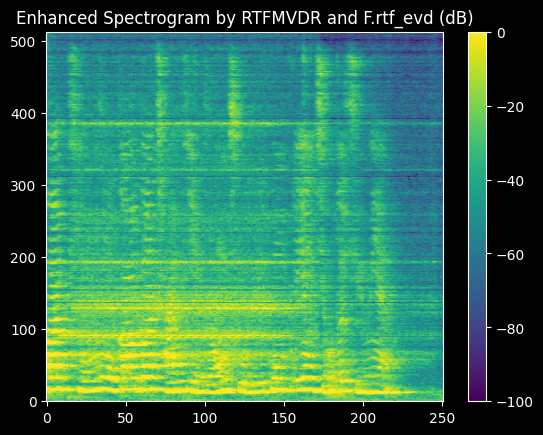

In [20]:
plot_spectrogram(stft_rtf_evd, "Enhanced Spectrogram by RTFMVDR and F.rtf_evd (dB)")
waveform_rtf_evd = waveform_rtf_evd.reshape(1, -1)
evaluate(waveform_rtf_evd, waveform_clean[0:1])
Audio(waveform_rtf_evd, rate=SAMPLE_RATE)

### 6.4. Result for RTFMVDR with `rtf_power`




AttributeError: `np.Inf` was removed in the NumPy 2.0 release. Use `np.inf` instead.

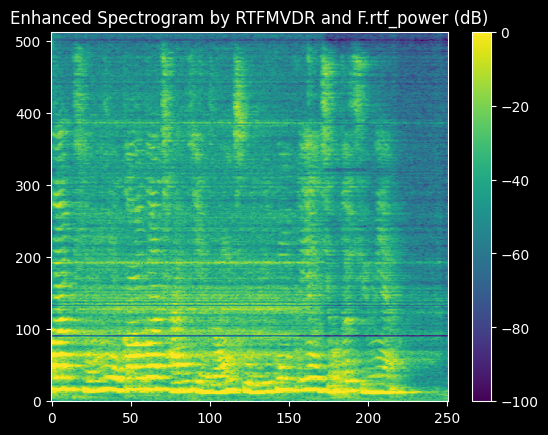

In [21]:
plot_spectrogram(stft_rtf_power, "Enhanced Spectrogram by RTFMVDR and F.rtf_power (dB)")
waveform_rtf_power = waveform_rtf_power.reshape(1, -1)
evaluate(waveform_rtf_power, waveform_clean[0:1])
Audio(waveform_rtf_power, rate=SAMPLE_RATE)